In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor





In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/DATA_MINING_PROJECT/'
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/My Drive/DATA_MINING_PROJECT


In [3]:
# Load the datasets
train_data = 'Data_Mining-master/train.csv'
test_data = 'Data_Mining-master/test.csv'
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
# Convert 'date' columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [7]:
# Encode the 'family' categorical data
label_encoder = LabelEncoder()
train_df['family_encoded'] = label_encoder.fit_transform(train_df['family'])
test_df['family_encoded'] = label_encoder.transform(test_df['family'])

# Normalize the 'sales' and 'onpromotion' features
sales_scaler = MinMaxScaler()
onpromotion_scaler = MinMaxScaler()
train_df['sales'] = sales_scaler.fit_transform(train_df[['sales']])
train_df['onpromotion'] = onpromotion_scaler.fit_transform(train_df[['onpromotion']])
test_df['onpromotion'] = onpromotion_scaler.transform(test_df[['onpromotion']])

In [8]:
# Aggregate data to monthly sales per store per family
train_df['year_month'] = train_df['date'].dt.to_period('M')
test_df['year_month'] = test_df['date'].dt.to_period('M')
monthly_train_df = train_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'sales': 'sum',
    'onpromotion': 'mean'
}).reset_index()
monthly_test_df = test_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'onpromotion': 'mean'
}).reset_index()

In [9]:
# Features and target for the model
features = monthly_train_df[['store_nbr', 'family_encoded', 'onpromotion']]
target = monthly_train_df['sales']

In [10]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

In [11]:
# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Cross-validate the model
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Make predictions on the test set
test_features = monthly_test_df[['store_nbr', 'family_encoded', 'onpromotion']]
test_predictions = rf_model.predict(test_features)

# Reverse the normalization to get actual sales predictions
predicted_sales = sales_scaler.inverse_transform(test_predictions.reshape(-1, 1))
monthly_test_df['predicted_sales'] = predicted_sales

# Output results
print("CV RMSE Scores:", cv_rmse_scores)
print("Average CV RMSE:", cv_rmse_scores.mean())
print(monthly_test_df.head())

CV RMSE Scores: [0.05721419 0.05856524 0.05758761 0.0644972  0.05734709]
Average CV RMSE: 0.059042263988909126
  year_month  store_nbr  family_encoded  onpromotion  predicted_sales
0    2017-08          1               0     0.000000        99.627679
1    2017-08          1               1     0.000000         0.000000
2    2017-08          1               2     0.001096        80.706667
3    2017-08          1               3     0.030617     60429.120000
4    2017-08          1               4     0.000000         3.507311


Validation RMSE: 0.05856499820640545


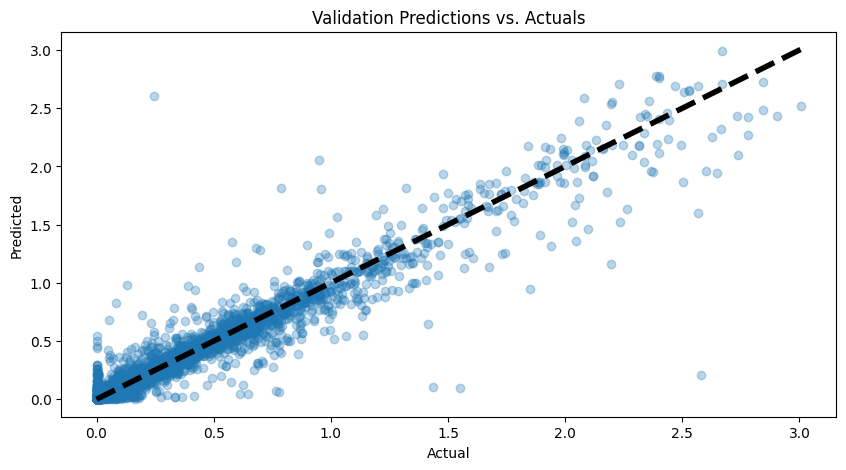

In [12]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Predict on the validation set
val_predictions = rf_model.predict(X_val)

# Calculate the RMSE on the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Print the validation RMSE
print("Validation RMSE:", val_rmse)

# Optionally, plot actual vs predicted values for further insight
plt.figure(figsize=(10, 5))
plt.scatter(y_val, val_predictions, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation Predictions vs. Actuals')
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]

}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to train the RandomForestRegressor
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Cross-validate the model with best parameters
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Make predictions on the test set with the best model
test_predictions = best_rf_model.predict(test_features)

# Reverse the normalization to get actual sales predictions
predicted_sales = sales_scaler.inverse_transform(test_predictions.reshape(-1, 1))
monthly_test_df['predicted_sales'] = predicted_sales

# Output results
print("CV RMSE Scores:", cv_rmse_scores)
print("Average CV RMSE:", cv_rmse_scores.mean())
print(monthly_test_df.head())

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
CV RMSE Scores: [0.05618217 0.0574899  0.05647137 0.06312562 0.05688671]
Average CV RMSE: 0.058031151456333016
  year_month  store_nbr  family_encoded  onpromotion  predicted_sales
0    2017-08          1               0     0.000000        99.769380
1    2017-08          1               1     0.000000         0.000000
2    2017-08          1               2     0.001096        84.082750
3    2017-08          1               3     0.030617     62852.524901
4    2017-08          1               4     0.000000         3.500627
